# imports

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import sklearn
import xgboost as xgb

# sklearn
from sklearn import model_selection # split함수이용
from sklearn import ensemble # RF,GBM
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# gnn
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv



/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops12split_Tensor4callERKNS_6TensorEN3c106SymIntEl
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/coco/anaconda3/en

In [2]:
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0].copy()
    df_minority = df[df.is_fraud==1].copy()
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled

def compute_time_difference(group):
    n = len(group)
    result = []
    for i in range(n):
        for j in range(n):
            time_difference = abs(group.iloc[i].trans_date_trans_time.value - group.iloc[j].trans_date_trans_time.value)
            result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
    return result

def mask(df):
    df_tr,df_test = sklearn.model_selection.train_test_split(df, random_state=42)
    N = len(df)
    train_mask = [i in df_tr.index for i in range(N)]
    test_mask = [i in df_test.index for i in range(N)]
    train_mask = np.array(train_mask)
    test_mask = np.array(test_mask)
    return train_mask, test_mask

def edge_index_selected(edge_index):
    theta = edge_index[:,2].mean()
    edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))
    edge_index = edge_index.tolist()
    mean_ = np.array(edge_index)[:,2].mean()
    selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > mean_]
    edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()
    return edge_index_selected




In [3]:
fraudTrain = pd.read_csv("~/Desktop/fraudTrain.csv").iloc[:,1:]

In [4]:
fraudTrain = fraudTrain.assign(trans_date_trans_time= list(map(lambda x: pd.to_datetime(x), fraudTrain.trans_date_trans_time)))
fraudTrain

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:00,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:00,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2020-03-10 16:07:00,6.011980e+15,fraud_Fadel Inc,health_fitness,77.00,Haley,Wagner,F,05561 Farrell Crescent,Annapolis,...,39.0305,-76.5515,92106,"Accountant, chartered certified",1943-05-28,45ecd198c65e81e597db22e8d2ef7361,1362931649,38.779464,-76.317042,0
1048571,2020-03-10 16:07:00,4.839040e+15,"fraud_Cremin, Hamill and Reichel",misc_pos,116.94,Meredith,Campbell,F,043 Hanson Turnpike,Hedrick,...,41.1826,-92.3097,1583,Geochemist,1999-06-28,c00ce51c6ebb7657474a77b9e0b51f34,1362931670,41.400318,-92.726724,0
1048572,2020-03-10 16:08:00,5.718440e+11,"fraud_O'Connell, Botsford and Hand",home,21.27,Susan,Mills,F,005 Cody Estates,Louisville,...,38.2507,-85.7476,736284,Engineering geologist,1952-04-02,17c9dc8b2a6449ca2473726346e58e6c,1362931711,37.293339,-84.798122,0
1048573,2020-03-10 16:08:00,4.646850e+18,fraud_Thompson-Gleason,health_fitness,9.52,Julia,Bell,F,576 House Crossroad,West Sayville,...,40.7320,-73.1000,4056,Film/video editor,1990-06-25,5ca650881b48a6a38754f841c23b77ab,1362931718,39.773077,-72.213209,0


> street/tsate/zip: 고객 거주지 정보
>
> lat/long: rhror wnthdp eogks dnleh alc rudeh
>
> city_pop: 고객의 zipcode에 속하는 인구 수
>
> job: 직업
>
> dob: 생년월일
> 
> trans_num: 거래번호
> 
> unix_time: 거래 시간(유닉스 타임 스탬프 형식)


## 데이터정리

In [5]:
_df1 = fraudTrain[fraudTrain["is_fraud"] == 0].sample(frac=0.20, random_state=42)
_df2 = fraudTrain[fraudTrain["is_fraud"] == 1]
df02 = pd.concat([_df1,_df2])
df02.shape

(214520, 22)

In [6]:
df50 = down_sample_textbook(df02)
df50 = df50.reset_index()
df50.shape

(12012, 23)

------------------------------------------------------------------------

### tr/test

In [7]:
mask(df50)

(array([False,  True,  True, ...,  True, False,  True]),
 array([ True, False, False, ..., False,  True, False]))

In [8]:
train_mask, test_mask = mask(df50)

In [9]:
df50_tr,df50_test = sklearn.model_selection.train_test_split(df50, random_state=42)

------------------------------------------------------------------------

### edge_index 설정

In [10]:
# groups = df50.groupby('cc_num')
# edge_index_list_plus = [compute_time_difference(group) for _, group in groups]
# edge_index_list_plus_flat = [item for sublist in edge_index_list_plus for item in sublist]
# edge_index_list_plus_nparr = np.array(edge_index_list_plus_flat)
# np.save('edge_index_list_plus50.npy', edge_index_list_plus_nparr)

In [11]:
edge_index = np.load('edge_index_list_plus50.npy').astype(np.float64)
edge_index.shape

(200706, 3)

In [12]:
edge_index_selected = edge_index_selected(edge_index)

---


### data설정(x, edge_index, y)

In [13]:
x = torch.tensor(df50['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df50['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[12012, 1], edge_index=[2, 93730], y=[12012], train_mask=[12012], test_mask=[12012])

---



## 분석 1(GCN)

In [15]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.902098,0.862478,0.95913,0.90824


In [16]:
gnn_fpr, gnn_tpr, gnn_thresholds  = roc_curve(yy, yyhat)
gnn_roc_auc_lr = auc(gnn_fpr, gnn_tpr)


---

## 분석2(로지스틱 회귀)

In [17]:
torch.manual_seed(202250926)
X = np.array(df50_tr.loc[:,['amt']])
XX = np.array(df50_test.loc[:,['amt']])
y = np.array(df50_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

lrnr = sklearn.linear_model.LogisticRegression()

lrnr.fit(X,y)

#thresh = y.mean()
#yyhat = (lrnr.predict_proba(XX)> thresh)[:,-1]
yyhat = lrnr.predict(XX) 

yyhat

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results2= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석2'])
_results2

,accuracy_score,precision_score,recall_score,f1_score
분석2,0.849484,0.933279,0.756098,0.835397


In [18]:
lr_fpr, lr_tpr, lr_thresholds  = roc_curve(yy, yyhat)
lr_roc_auc_lr = auc(lr_fpr, lr_tpr)


## 분석3(XGBoost)

In [19]:
import xgboost as xgb


torch.manual_seed(202250926)
X = np.array(df50_tr.loc[:, ['amt']])
XX = np.array(df50_test.loc[:, ['amt']])
y = np.array(df50_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

lrnr = xgb.XGBClassifier()
 
lrnr.fit(X,y)
yyhat = lrnr.predict(XX)


metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results3= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석3'])
_results3

,accuracy_score,precision_score,recall_score,f1_score
분석3,0.88012,0.886957,0.874094,0.880478


In [20]:
xg_fpr, xg_tpr, xg_thresholds  = roc_curve(yy, yyhat)
xg_roc_auc_lr = auc(xg_fpr, xg_tpr)


## 분석4(Light GBM)

In [21]:
import lightgbm as lgb

torch.manual_seed(202250926)
X = np.array(df50_tr.loc[:, ['amt']])
XX = np.array(df50_test.loc[:, ['amt']])
y = np.array(df50_tr.is_fraud)
yy = np.array(df50_test.is_fraud)


lrnr = lgb.LGBMClassifier()

lrnr.fit(X, y)
yyhat = lrnr.predict(XX)

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results4 = pd.DataFrame({m.__name__: [m(yy, yyhat).round(6)] for m in metrics}, index=['분석4'])
_results4


,accuracy_score,precision_score,recall_score,f1_score
분석4,0.885115,0.893817,0.87673,0.885191


In [23]:
gbm_roc_auc_lr

0.8852023411653126

In [22]:

gbm_fpr, gbm_tpr, gbm_thresholds  = roc_curve(yy, yyhat)
gbm_roc_auc_lr = auc(gbm_fpr, gbm_tpr)


---

# Roc curve

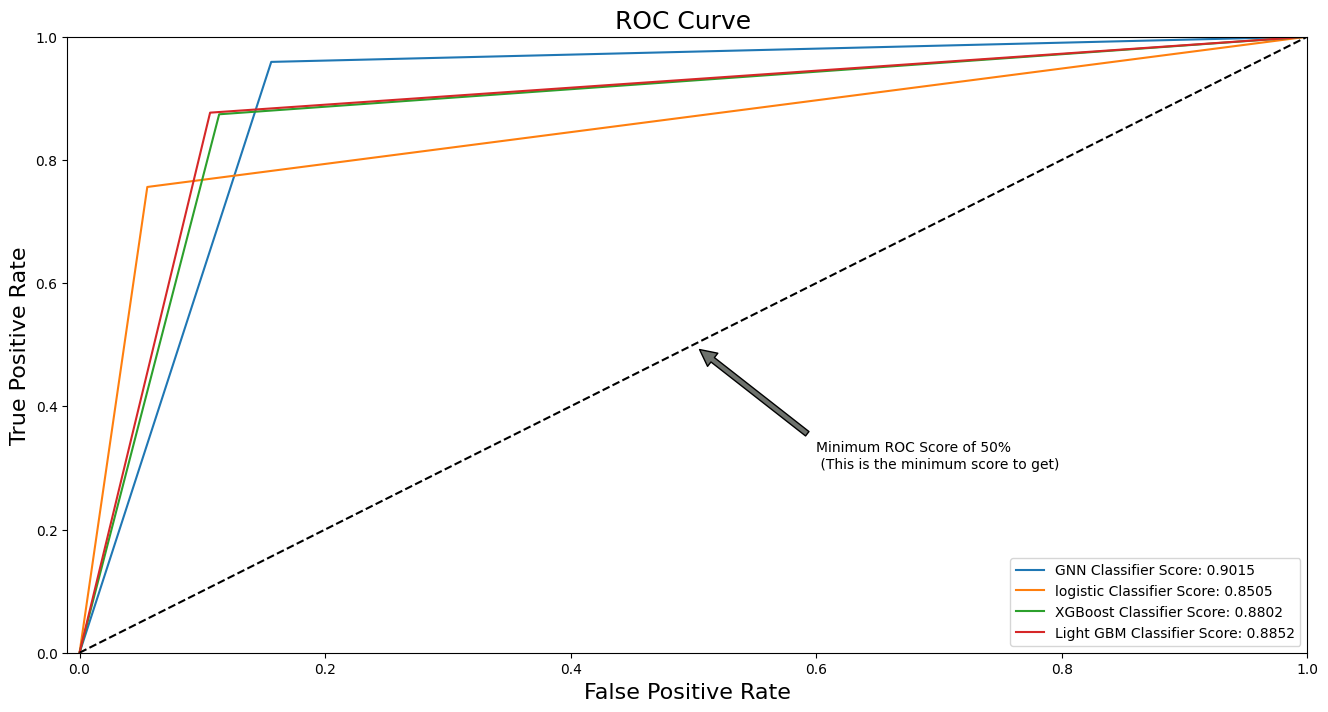

In [28]:
def graph_roc_curve_multiple(gnn_fpr, gnn_tpr, lr_fpr, lr_tpr, xg_fpr, xg_tpr, gbm_fpr, gbm_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve ', fontsize=18)
    plt.plot(gnn_fpr, gnn_tpr, label='GNN Classifier Score: {:.4f}'.format(gnn_roc_auc_lr))
    plt.plot(lr_fpr, lr_tpr, label='logistic Classifier Score: {:.4f}'.format(lr_roc_auc_lr))
    plt.plot(xg_fpr, xg_tpr, label='XGBoost Classifier Score: {:.4f}'.format(xg_roc_auc_lr))
    plt.plot(gbm_fpr, gbm_tpr, label='Light GBM Classifier Score: {:.4f}'.format(gbm_roc_auc_lr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(gnn_fpr, gnn_tpr, lr_fpr, lr_tpr, xg_fpr, xg_tpr, gbm_fpr, gbm_tpr)